In [1]:
from ls.configs.config_loader import load_config
from ls.data.icbhi_utils import (
    get_annotations,
    get_individual_cycles
)
from ls.data.transforms import generate_fbank

import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

In [2]:
from ls.configs.config_loader import load_config
# from ls.data.icbhi import build_dataloaders

cfg = load_config("../configs/config.yaml")

print("Dataset config:", cfg.dataset)
print("Audio config:", cfg.audio)

Dataset config: {'name': 'icbhi', 'data_folder': '/Users/gkont/Downloads/Datasets/icbhi_dataset', 'class_split': 'lungsound', 'split_strategy': 'official', 'n_cls': 4, 'weighted_sampler': False, 'batch_size': 8, 'num_workers': 4}
Audio config: {'sample_rate': 16000, 'desired_length': 8.0, 'pad_type': 'repeat', 'use_fade': True, 'fade_samples_ratio': 32, 'concat_aug_scale': 0.0, 'resz': 1.0, 'raw_augment': 0, 'specaug_policy': 'icbhi_ast_sup', 'specaug_mask': 'mean', 'n_mels': 128, 'frame_length': 40, 'frame_shift': 10, 'low_freq': 100, 'high_freq': 8000, 'window_type': 'hanning', 'use_energy': False, 'dither': 0.0, 'ast': True}


In [3]:
# --- 2. Load annotations ---
annotations = get_annotations(cfg.dataset.data_folder, cfg.dataset.class_split)
print(f"Found {len(annotations)} files with annotations.")

# Show one example file
first_key = next(iter(annotations.keys()))
print("Example recording:", first_key)
print(annotations[first_key].head())

Found 920 files with annotations.
Example recording: 148_1b1_Al_sc_Meditron
   Start    End  Crackles  Wheezes
0  0.022  0.364         0        0
1  0.364  2.436         0        0
2  2.436  4.636         0        0
3  4.636  6.793         0        0
4  6.793  8.750         0        0


In [4]:
# --- 3. Extract cycles for first file ---
cycles = get_individual_cycles(
    annotations[first_key],
    cfg.dataset,
    cfg.audio,
    filename=first_key,
)

print(f"Extracted {len(cycles)} cycles from {first_key}")
cycle_id = 3
waveform, label = cycles[cycle_id]
print("Waveform shape:", waveform.shape, " Label:", label)

Extracted 11 cycles from 148_1b1_Al_sc_Meditron
Waveform shape: torch.Size([1, 128000])  Label: 0


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [5]:
# --- 4. Generate mel fbank features ---
fbank = generate_fbank(waveform, cfg.audio)
print("Fbank shape:", fbank.shape)

Fbank shape: torch.Size([797, 128, 1])


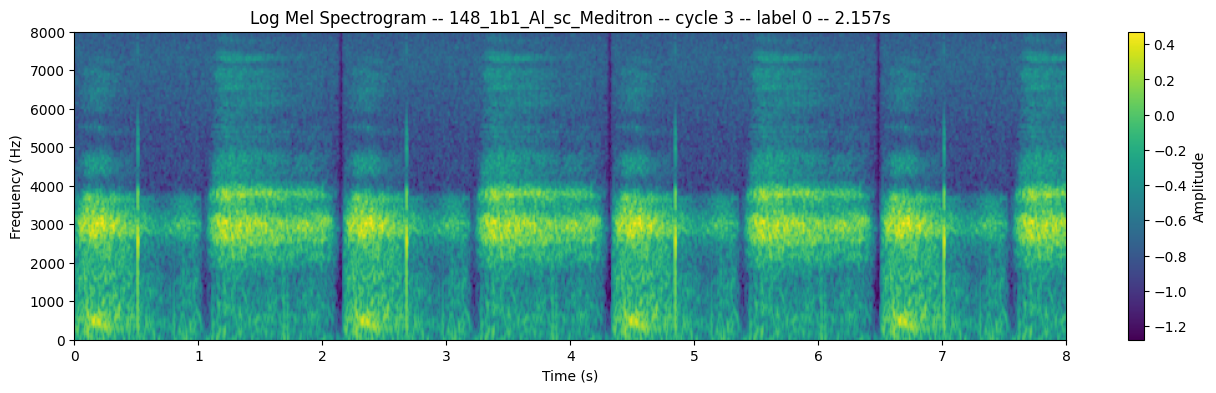

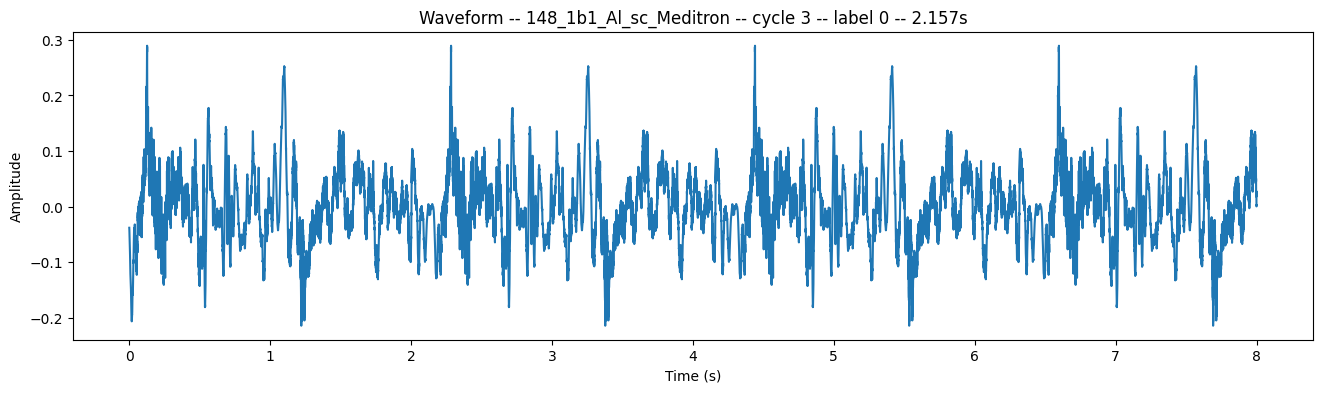

In [6]:
x_axis = np.linspace(0, cfg.audio.desired_length, fbank.shape[0])
freq_axis = np.linspace(0, 8000, fbank.shape[1])
orig_dur = annotations[first_key].iloc[cycle_id, 1] - annotations[first_key].iloc[cycle_id, 0]

plt.figure(figsize=(16, 4))
plt.imshow(fbank.squeeze(-1).T, aspect="auto", extent=[0, x_axis[-1], 0, freq_axis[-1]], origin="lower")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Amplitude")
plt.title(f"Log Mel Spectrogram -- {first_key} -- cycle {3} -- label {label} -- {orig_dur}s")
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(np.linspace(0, cfg.audio.desired_length, waveform.shape[1]), waveform.squeeze(0).numpy())
plt.title(f"Waveform -- {first_key} -- cycle {3} -- label {label} -- {orig_dur}s")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

ipd.Audio(waveform.numpy(), rate=16000)